In [102]:
import numpy as np
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.constants import mu_0

import visit_writer

import structured_3d_vtk as struc_3d

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

# Define functions

In [2]:
def prepare_idl_quantity(name, planes):
    r"""
    """
    measurements = struc_3d.read_idl(name)
    for plane in planes:
        measurements[plane] = struc_3d.average_duplicate_points(measurements[plane])
    return measurements

In [3]:
def combine_all_planes(measurements, planes):
    r"""
    """
    all_planes = dict(measurements[planes[0]])
    all_planes['z_out'] = planes[0]*np.ones(all_planes['x_out'].size)
 
    for plane in planes[1:]:
        for key in ['x_out', 'y_out']:
            all_planes[key] = np.concatenate((all_planes[key], 
                                              measurements[plane][key]))
        all_planes['z_out'] = np.concatenate((all_planes['z_out'],
                                              plane*np.ones(measurements[plane]['x_out'].size)))
        for key in ['std', 'a_out']:
            for time_point in xrange(measurements[plane]['delays'].size):
                all_planes[key][time_point] = np.concatenate((all_planes[key][time_point], 
                                                              measurements[plane][key][time_point]))
    return all_planes

In [4]:
def remove_points_outside_convex(measurements,
                                 x_min= -0.025, x_max=0.025,
                                 y_min=-0.016, y_max=0.017,
                                 z_min=0.249, z_max=0.416):
    r"""
    """
    points = np.dstack((measurements['x_out'], 
                        measurements['y_out'], 
                        measurements['z_out']))[0]
    outside_convex_volume = np.where(np.logical_or.reduce((points[:, 0] < x_min, 
                                                           points[:, 0] > x_max, 
                                                           points[:, 1] < y_min,
                                                           points[:, 1] > y_max,
                                                           points[:, 2] < z_min,
                                                           points[:, 2] > z_max)))[0]
    for key in ['x_out', 'y_out', 'z_out']:
        measurements[key] = np.delete(measurements[key], 
                                      outside_convex_volume)
    for key in ['std', 'a_out']:
        for time_point in xrange(measurements['delays'].size):
            measurements[key][time_point] = np.delete(measurements[key][time_point], 
                                                      outside_convex_volume)
    return measurements

In [5]:
def prepare_for_unstructured_vtk(measurements, quantity_name):
    r"""
    """
    points = np.dstack((measurements['x_out'], 
                        measurements['y_out'], 
                        measurements['z_out']))[0]
    triangulation = Delaunay(points)
    points = tuple(points.ravel())
    connectivity = tuple([(visit_writer.tetrahedron, int(simplex[0]), 
                           int(simplex[1]), int(simplex[2]), int(simplex[3])) 
                           for simplex in triangulation.simplices])
    variables_all_time = []
    for time_point in xrange(measurements['delays'].size):
        variables = ((quantity_name, 1, 1, tuple(measurements['a_out'][time_point])),)
        variables_all_time.append(variables)
    return points, connectivity, variables_all_time

In [6]:
def give_delaunay_and_interpolator(measurements):
    r"""
    """
    points = np.dstack((measurements['x_out'], 
                        measurements['y_out'], 
                        measurements['z_out']))[0]
    triangulation = Delaunay(points)
    interpolators = []
    for time_point in xrange(measurements['delays'].size):
        interpolators.append(LinearNDInterpolator(points, measurements['a_out'][time_point]))
    return triangulation, interpolators

In [7]:
def write_all_time_unstructured(file_prefix, points, connectivity, variables_all_time):
    r"""
    """
    for time_point in xrange(len(variables_all_time)):
        path = file_prefix + str(time_point).zfill(4)
        visit_writer.WriteUnstructuredMesh(path, 1, points,
                                           connectivity, 
                                           variables_all_time[time_point])

In [8]:
def save_idl_quantity_to_unstructured_grids(idl_quantity_name,
                                            visit_quantity_name,
                                            date, 
                                            planes=[0.249, 0.302, 0.357, 0.416],
                                            file_name_descriptor='_all_planes_convex_unstructured_grid_',
                                            x_min= -0.021, x_max=0.014,
                                            y_min=-0.016, y_max=0.017,
                                            z_min=0.249, z_max=0.416):
    r"""
    """
    file_prefix = '../output/' + date + '/' + visit_quantity_name + file_name_descriptor
    measurements = prepare_idl_quantity(idl_quantity_name, planes)
    all_planes = combine_all_planes(measurements, planes) 
    all_planes = remove_points_outside_convex(all_planes, 
                                              x_min=x_min, x_max=x_max,
                                              y_min=y_min, y_max=y_max,
                                              z_min=z_min, z_max=z_max)
    assert len(all_planes['x_out']) == len(all_planes['y_out']) == len(all_planes['z_out'])
    (points, 
     connectivity, 
     variables_all_time) = prepare_for_unstructured_vtk(all_planes, visit_quantity_name)
    assert len(points) == len(all_planes['x_out'])*3
    assert len(variables_all_time[0][0][3]) == len(all_planes['x_out'])
    write_all_time_unstructured(file_prefix, points, 
                                connectivity, variables_all_time)
    return all_planes 

In [9]:
def triangulate_derivatives(mesh, triangulation, interpolators, increment=0.00001):
    r"""
    """
    derivative_meshes = []
    for time_point in xrange(len(interpolators)):
        print time_point
        interpolator = interpolators[time_point]
        d_dx_mesh = np.zeros(mesh[0].shape)
        d_dy_mesh = np.zeros(mesh[0].shape)
        d_dz_mesh = np.zeros(mesh[0].shape)
        points = np.dstack((mesh[0].ravel(),
                            mesh[1].ravel(),
                            mesh[2].ravel()))
        values = interpolator(points)
        d_dx = (interpolator(points + np.asarray([increment, 0, 0])) - values) / increment
        d_dy = (interpolator(points + np.asarray([0, increment, 0])) - values) / increment
        d_dz = (interpolator(points + np.asarray([0, 0, increment])) - values) / increment
        d_dx_mesh = d_dx.reshape(mesh[0].shape)
        d_dy_mesh = d_dy.reshape(mesh[0].shape)
        d_dz_mesh = d_dz.reshape(mesh[0].shape)
        derivative_meshes.append([d_dx_mesh, d_dy_mesh, d_dz_mesh])
    return derivative_meshes

In [85]:
def remove_edges(mesh, derivative_meshes,
                 x_start=1, x_end=None, 
                 y_start=0, y_end=-2, 
                 z_start=0, z_end=-1):
    r"""
    """
    for index in xrange(len(mesh)):
        mesh[index] = mesh[index][y_start:y_end, x_start:x_end, z_start:z_end]
    for time_point in xrange(len(derivative_meshes)):
        for index in xrange(len(derivative_meshes[time_point])):
            derivative_meshes[time_point][index] = derivative_meshes[time_point][index][y_start:y_end, x_start:x_end, z_start:z_end]
    return mesh, derivative_meshes

In [10]:
def prepare_for_rectilinear_grid(mesh, quantities, quantity_names):
    r"""
    """
    x = tuple(np.unique(mesh[0]))
    y = tuple(np.unique(mesh[1]))
    z = tuple(np.unique(mesh[2]))
    variables_all_time = []
    for time_point in xrange(len(quantities)):
        variables = [(quantity_names[index], 1, 1, tuple(quantities[time_point][index].ravel()))
                     for index in xrange(len(quantities[time_point]))]
        variables_all_time.append(variables)
    return x, y, z, variables_all_time

In [ ]:
def current_on_mesh(derivative_meshes_all_directions, mu_0=1.2566e-6):
    r"""
    """
    current = []
    for time_point in xrange(len(derivative_meshes_all_directions[0])):
        dBx_dy = derivative_meshes_all_directions[0][time_point][1]
        dBx_dz = derivative_meshes_all_directions[0][time_point][2]
        dBy_dx = derivative_meshes_all_directions[1][time_point][0]
        dBy_dz = derivative_meshes_all_directions[1][time_point][2]
        dBz_dx = derivative_meshes_all_directions[2][time_point][0]
        dBz_dy = derivative_meshes_all_directions[2][time_point][1]
        j_x = 1./(mu_0) * (dBz_dy - dBy_dz)
        j_y = 1./(mu_0) * (dBx_dz - dBz_dx)
        j_z = 1./(mu_0) * (dBy_dx - dBx_dy)
    current.append([j_x, j_y, j_z])    
    return current

In [ ]:
def b_field_on_mesh(interpolators_all_directions, mesh):
    r"""
    """
    b_field = []
    b_field_norm[]
    for time_point in xrange(len(derivative_meshes_all_directions[0])):
        b_x = interpolators[0][time_point][mesh[0], mesh[1], mesh[2]]  
        b_y = interpolators[1][time_point][mesh[0], mesh[1], mesh[2]]
        b_z = interpolators[2][time_point][mesh[0], mesh[1], mesh[2]]
        b_x_norm = b_x / (b_x**2. + b_y**2. + b_z**2.)
        b_y_norm = b_y / (b_x**2. + b_y**2. + b_z**2.)
        b_z_norm = b_z / (b_x**2. + b_y**2. + b_z**2.)
        b_field.append([b_x, b_y, b_z])
        b_field_norm.append([b_x, b_y, b_z])
    return b_field

In [11]:
def write_fields_and_currents_to_structured_mesh(date, visit_quantity_names, mesh, x, y, z, derivative_meshes):
    r"""
    """
    file_prefix = '../output/' + date + '/' + visit_quantity_name
    for time_point in xrange(len(derivative_meshes)):
        path = file_prefix + str(time_point).zfill(4)  
        visit_writer.WriteRectilinearMesh(path, 1, x, y, z, 
                                          derivative_meshes[time_point])

# Write all idl quantities to files

In [57]:
bx_all_planes = save_idl_quantity_to_unstructured_grids('bx', 'B_x', '2016-07-26',
                                                        x_min=-0.032, x_max =0.028,
                                                        y_min=-0.022, y_max=0.032, 
                                                        z_min=0.249, z_max=0.416)

In [58]:
by_all_planes =save_idl_quantity_to_unstructured_grids('by', 'B_y', '2016-07-26',
                                                       x_min=-0.032, x_max =0.028,
                                                       y_min=-0.022, y_max=0.032, 
                                                       z_min=0.249, z_max=0.416)

In [59]:
bz_all_planes = save_idl_quantity_to_unstructured_grids('bz', 'B_z', '2016-07-26',
                                                        x_min=-0.032, x_max =0.028,
                                                        y_min=-0.022, y_max=0.032, 
                                                        z_min=0.249, z_max=0.416)

In [60]:
te_all_planes = save_idl_quantity_to_unstructured_grids('te', 'T_e', '2016-07-26', 
                                                        x_min=-0.026, x_max =0.028,
                                                        y_min=-0.03, y_max=0.028, 
                                                        z_min=0.249, z_max=0.416)

In [61]:
n_all_planes = save_idl_quantity_to_unstructured_grids('n', 'n', '2016-07-26',
                                                       x_min=-0.026, x_max =0.028,
                                                       y_min=-0.03, y_max=0.028, 
                                                       z_min=0.249, z_max=0.416)

# Determine derivatives and write to files

In [82]:
bx_triangulation, bx_interpolators = give_delaunay_and_interpolator(bx_all_planes)
by_triangulation, by_interpolators = give_delaunay_and_interpolator(by_all_planes)
bz_triangulation, bz_interpolators = give_delaunay_and_interpolator(bz_all_planes)

In [83]:
x_min = -0.026
x_max = 0.024
y_min = -0.02 
y_max = 0.028
z_min = 0.249 
z_max = 0.416
spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

In [86]:
date = '2016-07-29'
bx_derivative_meshes = triangulate_derivatives(mesh, bx_triangulation, bx_interpolators, 
                                               increment=0.0000001)
mesh, bx_derivative_meshes = remove_edges(mesh, bx_derivative_meshes)
x, y, z, dbx_all_time = prepare_for_rectilinear_grid(mesh, bx_derivative_meshes,
                                                     ['dbx_dx', 'dbx_dy', 'dbx_dz'])
write_derivatives_to_structured_mesh(date, 'dbx', mesh, x, y, z, dbx_all_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [93]:
np.sum(np.isnan(bx_derivative_meshes[19][0][:,:,:]))

0

In [94]:
date = '2016-07-29'
by_derivative_meshes = triangulate_derivatives(mesh, by_triangulation, by_interpolators, 
                                               increment=0.0000001)
mesh, by_derivative_meshes = remove_edges(mesh, by_derivative_meshes)
x, y, z, dby_all_time = prepare_for_rectilinear_grid(mesh, by_derivative_meshes, 
                                                     ['dby_dx', 'dby_dy', 'dby_dz'])
write_derivatives_to_structured_mesh(date, 'dby', mesh, x, y, z, dby_all_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


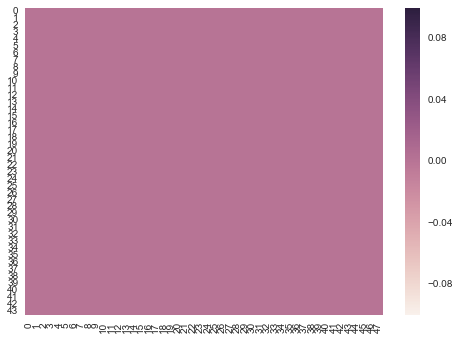

In [96]:
sns.heatmap(np.isnan(by_derivative_meshes[5][2][:,:,0]))
plt.show()

In [98]:
print np.sum(np.isnan(by_derivative_meshes[0][0][:,:,:]))

0


In [99]:
date = '2016-07-29'
bz_derivative_meshes = triangulate_derivatives(mesh, bz_triangulation, bz_interpolators, 
                                               increment=0.0000001)
mesh, bz_derivative_meshes = remove_edges(mesh, bz_derivative_meshes)
x, y, z, dbz_all_time = prepare_for_rectilinear_grid(mesh, bz_derivative_meshes, 
                                                     ['dbz_dx', 'dbz_dy', 'dbz_dz'])
write_derivatives_to_structured_mesh(date, 'dbz', mesh, x, y, z, dbz_all_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


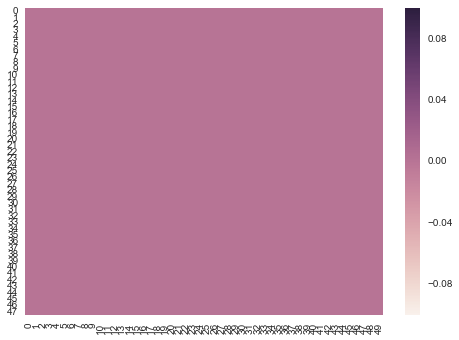

In [69]:
sns.heatmap(np.isnan(bz_derivative_meshes[5][2][:,:,0]))
plt.show()

In [100]:
np.unique(np.where(np.isnan(bz_derivative_meshes[0][1][:,:,:])))

array([], dtype=int64)

In [101]:
print np.sum(np.isnan(bz_derivative_meshes[0][1])[:,:,:])

0
